# 7 - Accelerating quantum processes

Last time, we saw hints of being able to accelerate quantum processes like spontaneous emission and excitation transfer by "delocalising" excitations across many TLS. 

In this tutorial, we'll see just how much speed-up we can get by developing a description of many TLS (called "Dicke states") that allows us to set up delocalised excitations easily and also helps us avoid getting stuck in a computational bottleneck. 



In [1]:
# Libraries and helper functions

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

import numpy as np
from itertools import product
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from qutip import *
from qutip.piqs import *
from qutip.cy.piqs import j_min, j_vals, m_vals

from scipy.stats import linregress
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

# The helper file below brings functions created in previous tutorials
from libs.helper_07_tutorial import *

## 7.1 -  Recap

So far, we've described a combined TLS + quantum field using a notation like, e.g. $|0,+,-,-,- \rangle$. The first number (in this case $0$) tells us the number of bosons present (this is often referred to as a [Fock state](https://en.wikipedia.org/wiki/Fock_state)), and the $\pm$ tell us what state each of the $N$ TLS are in ($+$ excited, $-$ ground). This is a complete description in the sense that every configuration of the system can be described as a mixture of these states. For example, a single excitation delocalised across 4 TLS with no bosons can be described by:

$\Psi_0 \sim | 0, +, -, -, - \rangle + | 0, -, +, -, - \rangle + | 0, -, -, +, - \rangle + | 0, -, -, -, + \rangle $


The issue with this description is that, for a specific number of bosons, there are $2^N$ possibilities for the state of the TLS and that means it becomes infeasible to simulate more than about 10 TLS.

Because delocalised excitations are of most interest to us today, we don't actually need a lot of the detail that the complete description holds. Superficially, we'd be quite happy with a simpler description like $| n, n_+ \rangle$ - where $n$ is the boson number and $n_+$ is the number of excitations. There would only be $N+1$  possibilities for the state of the TLS in this case - this is much more favourable from a computational perspective. 

Let's see if we can make this simpler description rigorous enough to help us with simulating many TLS.

## 7.2 - Angular momentum $J$ 

Creating a description of delocalised excitations is not quite as simple as $| n, n_+ \rangle$. For example, the following delocalised states contain the same number of delocalised excitations but they're different:

$\Psi_1 \sim | 0, +, - \rangle + | 0, -, + \rangle $

In [2]:
psi_1 = basis([2,2], [0,1]) + basis([2,2], [1,0])
psi_1 = psi_1.unit()
psi_1

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.        ]
 [0.70710678]
 [0.70710678]
 [0.        ]]

$\Psi_2 \sim | 0, +, - \rangle - | 0, -, + \rangle $

In [3]:
psi_2 = basis([2,2], [0,1]) - basis([2,2], [1,0])
psi_2 = psi_2.unit()
psi_2

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        ]
 [ 0.70710678]
 [-0.70710678]
 [ 0.        ]]

What makes these states physically different is related to what we normally think of as their angular momentum. We're therefore going to need to add some angular momentum information to our states. 

Ultimately, our states are going to need to look like:

$\Psi \sim | n, j, m \rangle$

Where:
- $n$ - boson number = $0,1,2,3,...$
- $j$ - [total angular momentum quantum number](https://en.wikipedia.org/wiki/Total_angular_momentum_quantum_number) = $0,\frac{1}{2},1,\frac{3}{2},2,\frac{5}{2}, 3, ...$
- $m$ - [magnetic quantum number](https://en.wikipedia.org/wiki/Magnetic_quantum_number) = $j, (j-1), (j-2), ..., -(j-2), -(j-1), -j$

It's not obvious where all those numbers come from and how they can be mapped to e.g. 4 TLS with a single delocalised excitation? So, let's figure that out.

### Angular momentum numbers

Although we don't explicitly have a description of angular momentum in our TLS, you may recall from tutorial 2 that our system is mathematically equivalent to spin 1/2 particles which do have angular momentum. We can also see this explicitly in the language we've been using to describe our Hamiltonian:

$$H =  \Delta E J_{Nz} + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)2J_{Nx}$$

In [4]:
H_latex = "$H = \Delta E J_{Nz} + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )2J_{Nx}$ "

where:

- The [total angular momentum operators](https://www2.ph.ed.ac.uk/~ldeldebb/docs/QM/lect15.pdf) ($J$) for $N$ TLS:

$$J_{Nx} = \overset{N}{\underset{n=1}{\Sigma}} S_{n x} \,\,\,\,\,\, J_{Ny} = \overset{N}{\underset{n=1}{\Sigma}} S_{n y} \,\,\,\,\,\, J_{Nz} = \overset{N}{\underset{n=1}{\Sigma}} S_{n z}$$

- The spin operators ($S$) for a [spin 1/2 particle](https://en.wikipedia.org/wiki/Spin-%C2%BD#Observables):

$$
S_x = \frac{1}{2}\sigma_x \,\,\,\,\,\, S_y = \frac{1}{2}\sigma_y \,\,\,\,\,\, S_z = \frac{1}{2}\sigma_z
$$

We'll continue to talk about angular momentum here to keep as sense of familiarity. Eventually we'll move to a more abstract way of thinking about $J$, but that can wait.

So far, we've seen that the x and z "components" of the total angular momentum operator $J_x$ and $J_z$ are used in the Hamiltonian. I use quote marks around "component" because this is vector language which is not obviously applicable to operators. It turns out, however, that we can (in some sense) treat the angular momentum operator as a vector (see [spinors](https://en.wikipedia.org/wiki/Spinors_in_three_dimensions)). We can create the squared "magnitude" of the total angular momentum operator ($J^2$) much like we would a vector by summing of the squares of the components.

Let's see this for the case of 2 TLS.

In [5]:
Jx, Jy, Jz = jspin(2, basis="uncoupled")
J2 = Jx*Jx + Jy*Jy + Jz*Jz

What does this operator tell us about how we might go about differentiating between states like $\Psi_1$ and $\Psi_2$ that have the same amount of delocalised excitation?

If $\Psi_1$ and $\Psi_2$ are eigenstates of $J^2$ (i.e. $J^2 \Psi = \lambda \Psi$) then those states have specific, well defined, angular momentum that's characterised by the constant (eigenvalue) $\lambda$. That constant could then be used to label our states.

In [6]:
J2*psi_1

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.        ]
 [1.41421356]
 [1.41421356]
 [0.        ]]

In [7]:
J2*psi_2

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]]

We can therefore see that:
- $J^2 \Psi_1 = 2 \Psi_1 \implies$  $\lambda = 2$
- $J^2 \Psi_2 = 0 \Psi_2 \implies$ $\lambda = 0$

Although not immediately obvious, these eigenvalues of $J^2$ [always have the form $j(j+1)$](https://www.feynmanlectures.caltech.edu/II_34.html#Ch34-S7), where $j$ is either an integer or half integer. 

In [8]:
evalsJ, eketsJ = J2.eigenstates()

In [9]:
evalsJ

array([0., 2., 2., 2.])

Without explicitly looking at all the eigenstates of $J^2$, we know there must be:
- 1 state with $j=0$ (we've seen that already with $\Psi_1$)
- 3 states with $j=1$ (we've seen one of those with $\Psi_2$)

You might wonder how we're able to have 3 states with the same angular momentum number $j$? They have different $J_z$ - what is known as the "magnetic quantum number" often given the label $m$. 

In quantum mechanics, it has been found experimentally that [angular momentum is quantised](https://www.feynmanlectures.caltech.edu/II_34.html#Ch34-S7) in the sense that when its z component is measured it can only take values $m\hbar$ where $m = j, (j-1), (j-2), ..., -(j-2), -(j-1), -j$. We can see this explicitly by looking at the eigenvalues of $J_z$.

In [10]:
evalsM, eketsM = Jz.eigenstates()

In [11]:
evalsM

array([-1.,  0.,  0.,  1.])

For $N=2$, the TLS can therefore be described in terms of angular momentum by giving 2 numbers $|j,m\rangle$:
- $| 0, 0 \rangle$ - this is $\Psi_1$
- $|1, -1 \rangle$
- $|1, 0 \rangle$ - this is $\Psi_2$
- $|1, 1\rangle$

This is actually a complete description because for 2 TLS there are only 4 states, $| -, - \rangle$, $| +, - \rangle$, $| -, + \rangle$, $| +, + \rangle$. This is not the case for $N>2$.  In general, we lose the ability to describe every state uniquely when we use this angular momentum description. In other words, there can be many states with the same $j,m$ values (degenerate states). When you enumerate all the states in the angular momentum description, there are $\sim N^2$ possibilities compared to the $2^N$ we've been working with up to now. This is ultimately what's going to give us a computational advantage but we do need to be a bit careful as to whether we lose any physics when we do this. 
> Advanced: Use [`state_degeneracy(N,j)`](https://qutip.org/docs/4.4/apidoc/functions.html?highlight=m_degeneracy#qutip.piqs.state_degeneracy) to calculate the degeneracy of each state. In general there are some subtleties to consider when ignoring degeneracy which might need to be considered depending on the problem at hand (see last paragraph of [Permutational Invariant Quantum Solver](http://qutip.org/docs/latest/guide/dynamics/dynamics-piqs.html)). For now, we don't need to worry about this so we will put a pin in this advanced topic and return to it in a later tutorial.


Hopefully you've got a better understanding of these angular momentum numbers. Now we need to link it back to the number of TLS $N$ and the number of delocalised excitations $n_+$.

### Dicke states

Consider 4 TLS with a single delocalised excitation, how can we write this in our new angular momentum description with $j,m$?

$m$ is actually very closely related to the number of excitations $n_{+}$, it's:

$$m= \frac{1}{2}\left(n_{+} - n_{-} \right) = \frac{1}{2}\left(n_{+} - (N - n_{+}) \right) = n_+ - N/2$$

For 4 TLS with a single delocalised excitation, we'd have $m = 1 - \frac{4}{2} = -1$. What about $j$?

As we saw earlier, there are several $j$'s for a given $m$. In general, the specific $j$, $m$ combinations come from adding up the angular momentum for many single TLS (with $j=1/2$) like vectors of the same length but different (quantised) orientations. The details are somewhat tedious - often involving [formidable lookup tables](http://pdg.lbl.gov/2019/reviews/rpp2019-rev-clebsch-gordan-coefs.pdf). Luckily for us, QuTiP, has some convenient functions (that are somewhat hidden inside of [`qutip.cy.piqs`](https://github.com/qutip/qutip/blob/85632bc66fdcd45be51e1c280ea7577f04761a67/qutip/cy/piqs.pyx)) to help us.
- [`j_vals(N)`](https://github.com/qutip/qutip/blob/85632bc66fdcd45be51e1c280ea7577f04761a67/qutip/cy/piqs.pyx#L130) - tells us the different $j$ values for $N$ TLS.
- [`m_vals(j)`](https://github.com/qutip/qutip/blob/85632bc66fdcd45be51e1c280ea7577f04761a67/qutip/cy/piqs.pyx#L147) tells us the $m$ values for a given $j$





In [12]:
j_vals(4) # Gives the different j's for 4 TLS

array([0., 1., 2.])

In [13]:
m_vals(2) # Gives us m values for j=2

array([-2, -1,  0,  1,  2])

In [14]:
m_vals(1) # Gives us m values for j=1

array([-1,  0,  1])

In [15]:
m_vals(0) # Gives us m values for j=0

array([0])

We can see that there is an $m=-1$ for $j=2$ and $j=1$. Which one should we pick?

By far the most significant $j$ is the largest $j_{\max} = N/2$. The largest $j$ corresponds to what's called a `Dicke state`. 

A Dicke state is a symmetric state, which means if you swap any of the TLS around, the state remains unchanged. For example, consider a single excitation in 4 TLS. The Dicke state looks like:

$\Psi_0 = \frac{1}{\sqrt{4}}\left(| 0, +, -, -, - \rangle + | 0, -, +, -, - \rangle + | 0, -, -, +, - \rangle + | 0, -, -, -, + \rangle \right)$

Notice that if you swap any two TLS, the state looks the same.

The reason why $j_{\max}$ is most significant is because of the acceleration properties that these Dicke states offer; something people often describe as superradiance and supertransfer. We're going to see this in action in the next section.

Before we get there, we need to take a short detour into angular momentum conservation.

### Conservation of angular momentum

Angular momentum is conserved in our model and so we have a choice which $j$ value we want to run our simulation with. Once we set the system up with this $j$ it will keep that same $j$. This gives us an additional computational advantage above what we've already got from using the angular momentum description.

Instead of needing to keep track of the $N^2$ different angular momentum states, we only need to keep track of the $2j+1$ different $m$ states that correspond to the $j$ we picked. The worst case scenario is the Dicke states which use $j_{\max} = N/2$. For simulating Dicke states we need to keep track of $N+1$ states. This is an incredible improvement - going from an exponential scaling with number of TLS to linear.

You might think it would be a pain to extract only the states that correspond to a particular $j$, but once again QuTiP has got our back  with [`jmat(j)`](https://qutip.org/docs/latest/apidoc/functions.html?highlight=jmat#qutip.operators.jmat) - it does 2 things:
- Automatically gives us operators in the angular momentum basis, i.e. $|j,m \rangle$
- Returns only parts of the operators that act on the $j$ we pick

Let's look at an example:

In [16]:
N = 2 # 2 TLS
Jx, Jy, Jz = jmat(N/2) # j=j_max = N/2 means only Dicke states allowed
Jz

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -1.]]

We've got a 3x3 matrix because there are only 3 states corresponding to $m=1,0,-1$ for $j=1$. The matrix also signposts to us QuTip's convention for labeling the angular momentum states.


$$
|1,1> = \begin{bmatrix}
 1   \\
 0   \\
 0   \\
 \end{bmatrix}, 
|1,0> = \begin{bmatrix}
 0   \\
 1   \\
0   \\
\end{bmatrix}, 
|1,-1> = \begin{bmatrix}
 0   \\
 0   \\
1   \\
\end{bmatrix}
$$

Largest $m$ at the top of the state vector, smallest $m$ at the bottom.

Ok, we're ready to explore the suped up version of quantum mechanics.

## 7.3 Superradiance

Let's reconsider the case of spontaneous emission. We saw in tutorial 3 that such emission from a TLS can be understood as the result of coupling to a quantised field. The stronger the coupling, the faster the emission as seen by the increased Rabi frequency.

For emission from many TLS, we'd expect the rate to depend on the number of TLS that are excited. We might argue, for example, that the rate of emission is simply the sum of the rates of the individual TLS. In other words, we'd expect a factor of $N$ speed-up for $N$ TLS that are excited.

Let's simulate it and check. We're going to need to make a some modifications to our simulation code and also how we measure "emission rates".

First, we need to adapt `make_operators` function to use `j = jmax` (i.e. we'll start with a Dicke state) and we'll also enumerate the states in `nm_list` in terms of number of TLS that are excited $n_+$ instead of using $m$. We can do this because:

$m = n_+ - N/2$$

Since $m = j, j-1,...-j$ and $N/2 = j$ for Dicke states, then $$n_+ = m+j = 2j, 2j-1, 2j-2, ..., 3,2,1,0$$



In [17]:
def make_operators(max_bosons=2, parity=0, num_TLS=1):

    jmax = num_TLS/2              # max j gives us Dicke states
    
    J     = jmat(jmax)
    Jx    = tensor(qeye(max_bosons+1), J[0])                                     # tensorised Jx operator
    Jz    = tensor(qeye(max_bosons+1), J[2])                                     # tensorised Jx operator
    a     = tensor(destroy(max_bosons+1), qeye(J[0].dims[0][0]))                 # tensorised boson destruction operator

    two_state     = Jz                                 # two state system energy operator   Jz
    bosons        = (a.dag()*a+0.5)                    # boson energy operator              𝑎†𝑎+1/2
    number        = a.dag()*a                          # boson number operator              𝑎†𝑎
    interaction   = 2*(a.dag() + a) * Jx                # interaction energy operator        2(𝑎†+𝑎)Jx  
    
    P = (1j*np.pi*(number + Jz + num_TLS/2)).expm()    # parity operator 
    
    # map from QuTiP number states to |n,m> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = range(int(2*jmax), -1, -1)
    nm_list = [(n,m) for (n,m) in product(possible_ns, possible_ms)]

    
    if (parity==1) | (parity==-1):
        p               = np.where(P.diag()==parity)[0]
    else:
        p               = np.where(P.diag()==P.diag())[0]
        
    two_state       = two_state.extract_states(p)
    bosons          = bosons.extract_states(p)
    number          = number.extract_states(p)
    interaction     = interaction.extract_states(p)
    nm_list        = [nm_list[i] for i in p]
  
    return two_state, bosons, interaction, number, nm_list

Next, we need to figure out how we're going to measure emission rates.

### Emission rates

So far in this tutorial series, we've been using the Rabi frequency $\Omega$ as a measure of the speed of quantum processes like spontaneous emission and excitation transfer. It's a useful metric for systems that exhibit a single Rabi frequency. However, it doesn't formally give us an emission/transfer/transition "rate". 

In quantum mechanics, the transition rate $\left(\Gamma\right)$ from a particular state $\Psi$ is defined by the rate of change of the probability to be in that state $P_{\Psi}$. In other words:

$$\Gamma = \frac{d P_\Psi}{dt}$$

$\Gamma$ essentially tells us how much probability has accumulated per unit time for a transition to occur.

Sometimes it can be more helpful to look at rate of change of the expectation values of certain operators, e.g. the boson number operator $a^{\dagger}a$. A rate defined by:

$$\Gamma = \frac{d \langle a^{\dagger}a \rangle}{dt}$$

gives us a more direct measure of boson emission rates.

In either case, the challenge for us is that these rates approach zero for short times because $P \sim \cos^2\left(... t \right)$ and $\langle a^{\dagger}a\rangle \sim \sin^2\left(... t  \right)$. This makes comparing rates for different numbers of TLS a numerical nightmare because we get uncomfortably close to doing $\frac{0}{0}$ 😬.

A solution is to create an analytical model of the dynamics at short times scales. Specifically, we can do a taylor expansion up to $t^2$:

$$\langle a^{\dagger}a\rangle = a + bt + ct^2$$

and because we expect $b=0$ (because $\Gamma \rightarrow 0$ as $t \rightarrow 0$), we get the following rate:

$$\frac{d \langle a^{\dagger}a \rangle}{dt} = 2ct$$

With this expression, comparing rates between different scenarios (1 and 2) works out to be the ratio of the expansion coefficients:

$$\frac{\Gamma_1}{\Gamma_2} = \frac{c_1}{c_2}$$

no nasty divide by zero problem 🙌.

We can us SciPy's [`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) to extract the expansion coefficients we need.

Let's do it!

### Fully excited system

In [192]:
# a + bt + ct^2. 
# a=0 because number of bosons 0 to start
# b=0 because (from experience) rate is 0 to start 
def model_func(t, c):
    return c*t**2

In [193]:
DeltaE = 1 # We match the boson energy to the TLS energy to make sure we'll get emission like behaaviour
omega = 1
U = 0.001 # Coupling is 10x lower than the last tutorial because we are upping the number of TLS

10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.02s. Est. time left: 00:00:00:00
30.0%. Run time:   0.04s. Est. time left: 00:00:00:00
40.0%. Run time:   0.05s. Est. time left: 00:00:00:00
50.0%. Run time:   0.05s. Est. time left: 00:00:00:00
60.0%. Run time:   0.06s. Est. time left: 00:00:00:00
70.0%. Run time:   0.07s. Est. time left: 00:00:00:00
80.0%. Run time:   0.08s. Est. time left: 00:00:00:00
90.0%. Run time:   0.09s. Est. time left: 00:00:00:00
Total run time:   0.11s


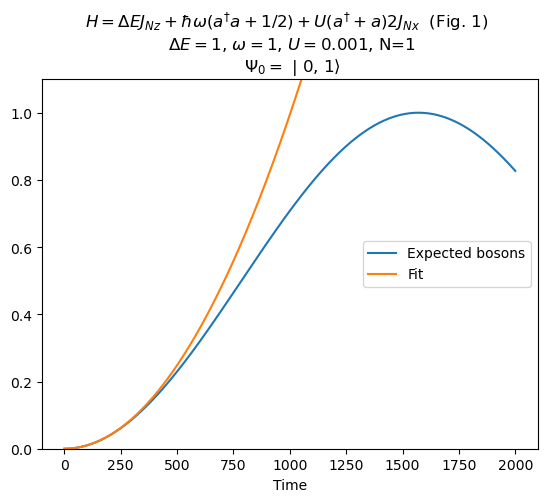

10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.02s. Est. time left: 00:00:00:00
30.0%. Run time:   0.03s. Est. time left: 00:00:00:00
40.0%. Run time:   0.04s. Est. time left: 00:00:00:00
50.0%. Run time:   0.05s. Est. time left: 00:00:00:00
60.0%. Run time:   0.06s. Est. time left: 00:00:00:00
70.0%. Run time:   0.07s. Est. time left: 00:00:00:00
80.0%. Run time:   0.08s. Est. time left: 00:00:00:00
90.0%. Run time:   0.09s. Est. time left: 00:00:00:00
Total run time:   0.10s


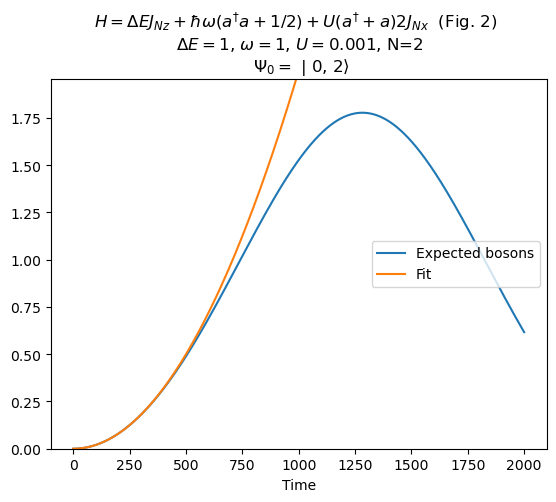

10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.02s. Est. time left: 00:00:00:00
30.0%. Run time:   0.04s. Est. time left: 00:00:00:00
40.0%. Run time:   0.05s. Est. time left: 00:00:00:00
50.0%. Run time:   0.06s. Est. time left: 00:00:00:00
60.0%. Run time:   0.08s. Est. time left: 00:00:00:00
70.0%. Run time:   0.09s. Est. time left: 00:00:00:00
80.0%. Run time:   0.10s. Est. time left: 00:00:00:00
90.0%. Run time:   0.12s. Est. time left: 00:00:00:00
Total run time:   0.13s


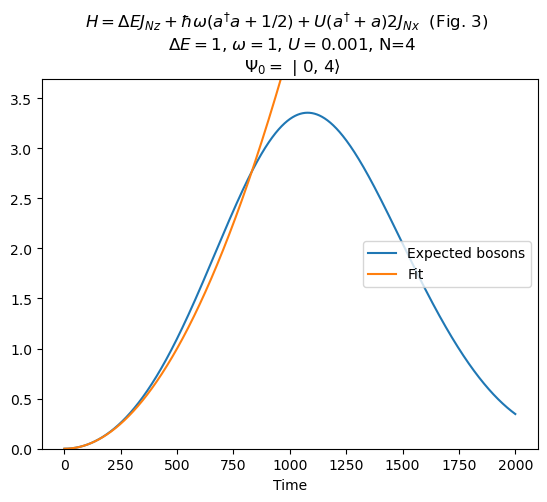

10.0%. Run time:   0.02s. Est. time left: 00:00:00:00
20.0%. Run time:   0.05s. Est. time left: 00:00:00:00
30.0%. Run time:   0.07s. Est. time left: 00:00:00:00
40.0%. Run time:   0.10s. Est. time left: 00:00:00:00
50.0%. Run time:   0.12s. Est. time left: 00:00:00:00
60.0%. Run time:   0.15s. Est. time left: 00:00:00:00
70.0%. Run time:   0.17s. Est. time left: 00:00:00:00
80.0%. Run time:   0.19s. Est. time left: 00:00:00:00
90.0%. Run time:   0.22s. Est. time left: 00:00:00:00
Total run time:   0.24s


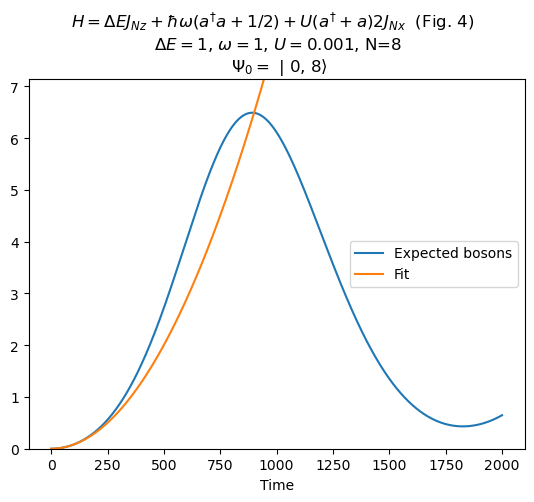

10.0%. Run time:   0.07s. Est. time left: 00:00:00:00
20.0%. Run time:   0.16s. Est. time left: 00:00:00:00
30.0%. Run time:   0.24s. Est. time left: 00:00:00:00
40.0%. Run time:   0.33s. Est. time left: 00:00:00:00
50.0%. Run time:   0.41s. Est. time left: 00:00:00:00
60.0%. Run time:   0.50s. Est. time left: 00:00:00:00
70.0%. Run time:   0.58s. Est. time left: 00:00:00:00
80.0%. Run time:   0.66s. Est. time left: 00:00:00:00
90.0%. Run time:   0.75s. Est. time left: 00:00:00:00
Total run time:   0.83s


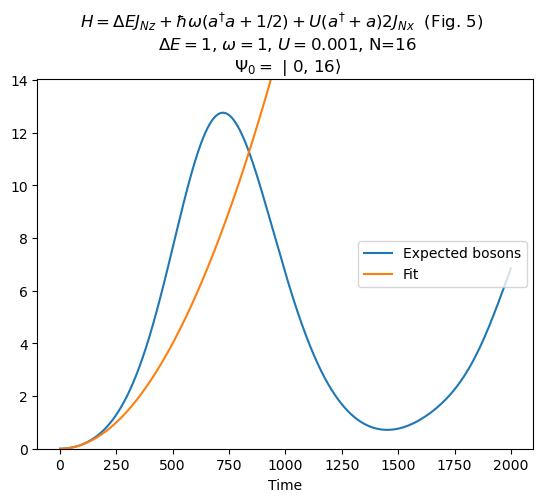

10.0%. Run time:   0.44s. Est. time left: 00:00:00:03
20.0%. Run time:   0.97s. Est. time left: 00:00:00:03
30.0%. Run time:   1.45s. Est. time left: 00:00:00:03
40.0%. Run time:   1.97s. Est. time left: 00:00:00:02
50.0%. Run time:   2.47s. Est. time left: 00:00:00:02
60.0%. Run time:   2.97s. Est. time left: 00:00:00:01
70.0%. Run time:   3.50s. Est. time left: 00:00:00:01
80.0%. Run time:   3.99s. Est. time left: 00:00:00:00
90.0%. Run time:   4.48s. Est. time left: 00:00:00:00
Total run time:   5.01s


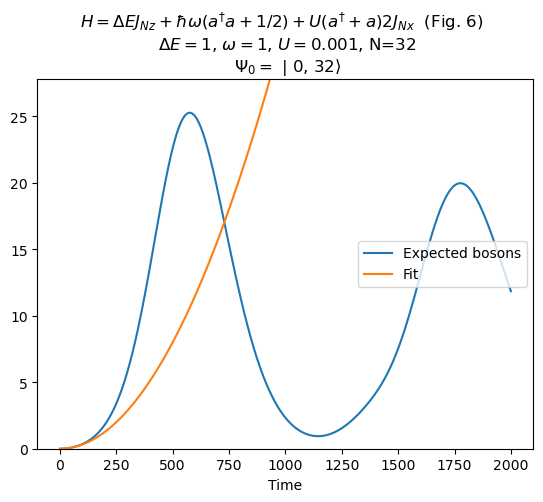

10.0%. Run time:   3.31s. Est. time left: 00:00:00:29
20.0%. Run time:   6.50s. Est. time left: 00:00:00:25
30.0%. Run time:   9.69s. Est. time left: 00:00:00:22
40.0%. Run time:  12.85s. Est. time left: 00:00:00:19
50.0%. Run time:  16.08s. Est. time left: 00:00:00:16
60.0%. Run time:  19.23s. Est. time left: 00:00:00:12
70.0%. Run time:  22.54s. Est. time left: 00:00:00:09
80.0%. Run time:  25.73s. Est. time left: 00:00:00:06
90.0%. Run time:  28.88s. Est. time left: 00:00:00:03
Total run time:  32.10s


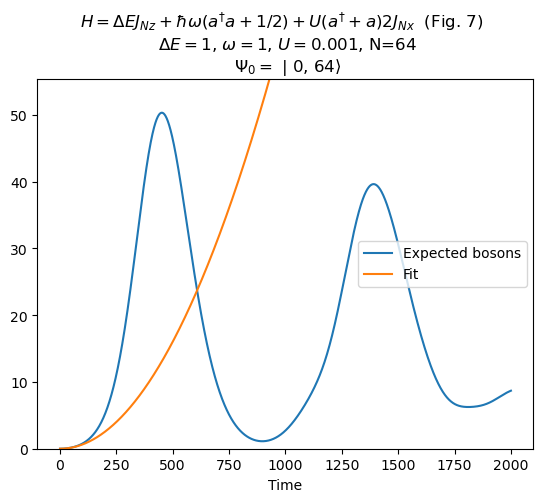

10.0%. Run time:  34.47s. Est. time left: 00:00:05:10
20.0%. Run time:  72.52s. Est. time left: 00:00:04:50
30.0%. Run time: 110.19s. Est. time left: 00:00:04:17
40.0%. Run time: 147.09s. Est. time left: 00:00:03:40
50.0%. Run time: 184.74s. Est. time left: 00:00:03:04
60.0%. Run time: 222.46s. Est. time left: 00:00:02:28
70.0%. Run time: 259.82s. Est. time left: 00:00:01:51
80.0%. Run time: 297.10s. Est. time left: 00:00:01:14
90.0%. Run time: 334.94s. Est. time left: 00:00:00:37
Total run time: 372.49s


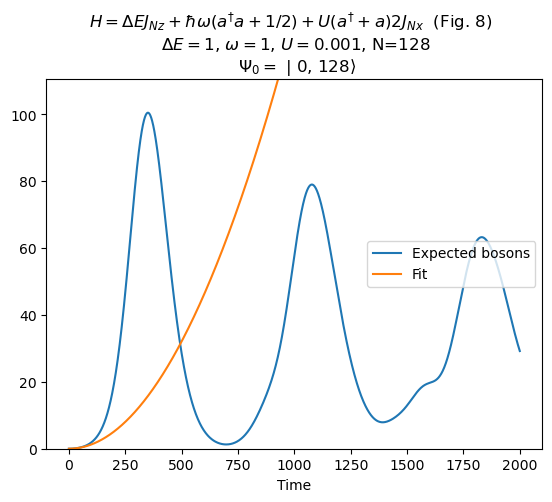

CPU times: user 7min 5s, sys: 6.86 s, total: 7min 12s
Wall time: 7min 3s


In [194]:
%%time 
# %%time must be at the top of the cell and by itself. It tells you the "Wall time" (how long the cell took to run) at the end of the output (should be about 2 min).

Ns = [1,2,4,8,16,32,64,128] # number of TLS we want to simulation
times = np.linspace(0,  2000, 2000)
rate = [] # For storing emission rates

for i, N in enumerate(Ns):
    if N==1:
        # For N=1 the parity is opposite to the other N's
        two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=N+1, parity=-1, num_TLS=N)
    else:
        two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=N+1, parity=1, num_TLS=N)

    bra_labels, ket_labels = make_braket_labels(nm_list)
    
    H = DeltaE*two_state + omega*bosons + U*interaction

    psi0_ind = nm_list.index((0,N))  # Field in vacuum state (0) with N excitations (N)
    psi0 = basis(len(nm_list), psi0_ind)


    # We can use use QuTips sesolve here because of the shorter
    # simulation time. Sometimes sesolve is still fastser than
    # our custom solver because of unknown optimisations made
    # made the QuTip/Numpy teams.
    # Note progress bar because the last simulation will take about 5 min
    result = sesolve(H, psi0, times, [number], progress_bar=True)

    # For fitting, we'll find when the first boson is emitted, then re-simulate 
    # up to that pointso that we can get a better resolution over the shorter time periods.
    # We do this because we expect timescales to shorten as we increase TLS number
    if N==1:
        # N=1 is special because number of bosons never crosses 1 so we need to use find_peaks just like in the last tutorial
        peaks, _ = find_peaks(result.expect[0], prominence=0.05)
        peak_times = times[peaks]
        time_to_emit_one = peak_times[0]
    else: 
        # Approximate time when the expected bosons reaches 1. We look for when expected bosons crosses 1.
        crossing_one_index = np.where(np.diff((result.expect[0] > 1).astype(int)))[0][0]
        time_to_emit_one = times[crossing_one_index]

    times_fit = np.linspace(0,  time_to_emit_one, 1000)
    result_fit = sesolve(H, psi0, times_fit, [number])

    fit, covariance = curve_fit(model_func, times_fit[0:100], result_fit.expect[0][0:100],p0=[0.01],maxfev=500)

    rate.append(2*fit[0])


    plt.plot(times, result.expect[0], label="Expected bosons")
    plt.plot(times,model_func(times,*fit),label="Fit")
    plt.xlabel("Time")
    plt.ylim([0,result.expect[0].max()*1.1])
    plt.legend(loc="right")
    plt.title(f"{H_latex} (Fig. {i+1})  \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, N={N} \n $\Psi_0 =$ {ket_labels[psi0_ind]}")
    plt.show();

Although superficially our model fit doesn't look great in e.g. Fig. 8, you'll notice that if we plot for short time scales over which the model was fitted it's fine.

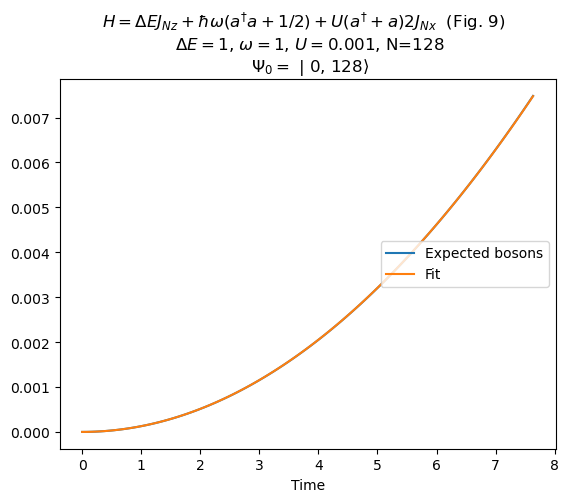

In [195]:
plt.plot(times_fit[0:100], result_fit.expect[0][0:100], label="Expected bosons")
plt.plot(times_fit[0:100],model_func(times_fit[0:100],*fit),label="Fit")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title(f"{H_latex} (Fig. 9)  \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, N={N} \n $\Psi_0 =$ {ket_labels[psi0_ind]}")
plt.show();

We'll store the "base" rate of emission $\Gamma_1$ for the case of a single TLS so that we might reference it later

In [196]:
gamma_1 = rate[0]
gamma_1

1.9883956057828223e-06

Let's now see how the emission rate varies with with number of TLS $N$. 

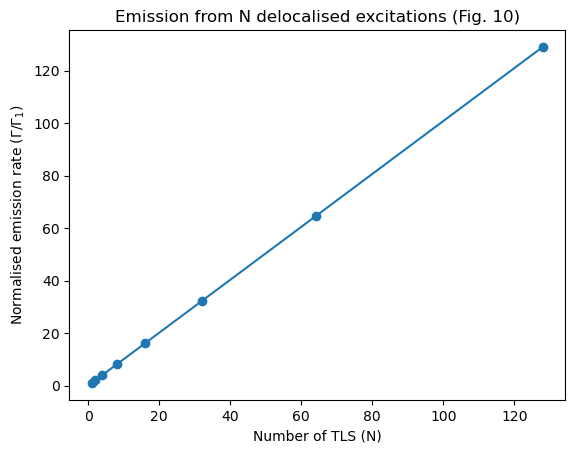

In [197]:
plt.plot(Ns,rate/gamma_1,"-o")
plt.xlabel("Number of TLS (N)")
plt.ylabel("Normalised emission rate ($\Gamma/\Gamma_1$)");
plt.title("Emission from N delocalised excitations (Fig. 10)");

Fig. 9 shows us exactly what we expected - a nice linear relationship.

Let's not celebrate too soon though.

If we apply our intuition to the case of a single delocalised excitation spread acorss $N$ TLS, then we'd expect the emission rates to be independent of $N$. This is however not the case. 

Let's see.

### Single delocalised excitation

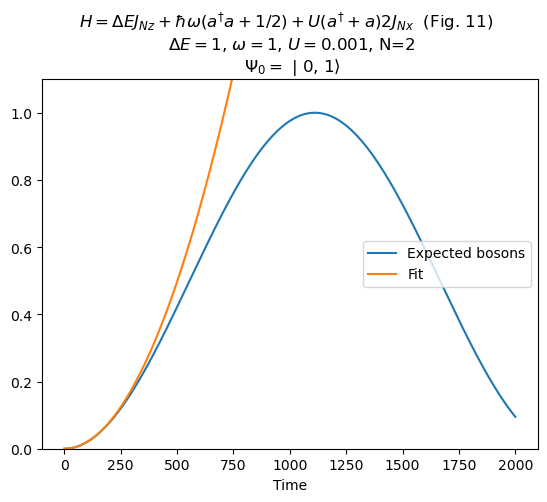

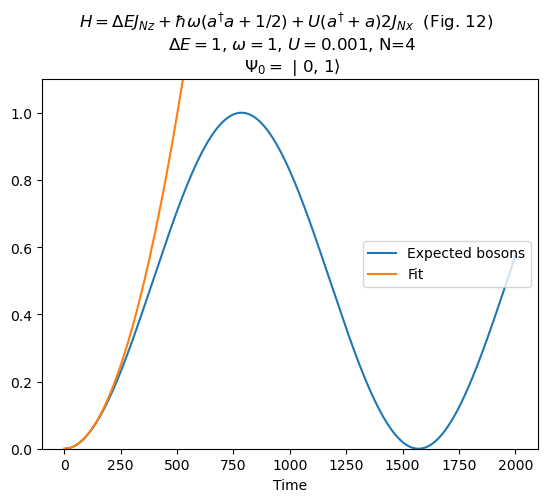

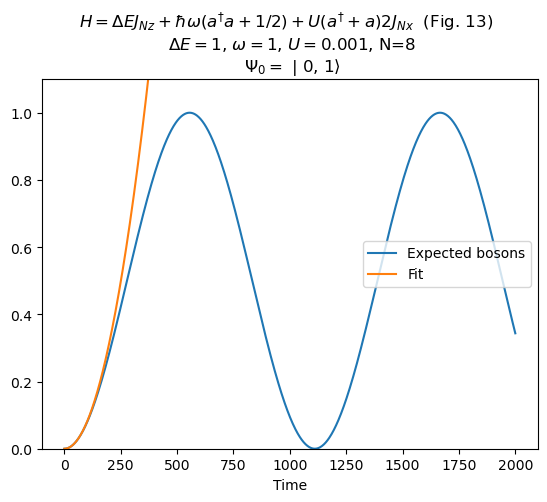

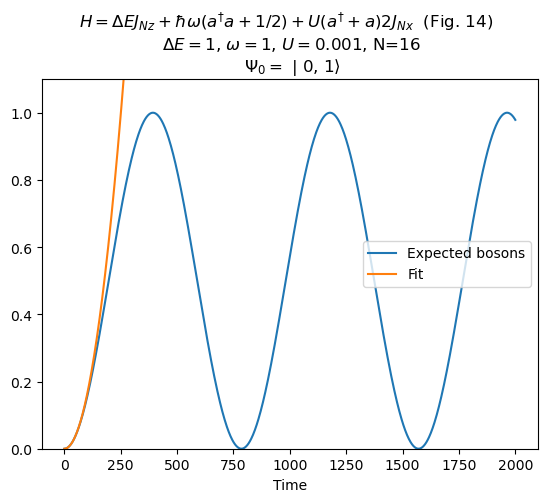

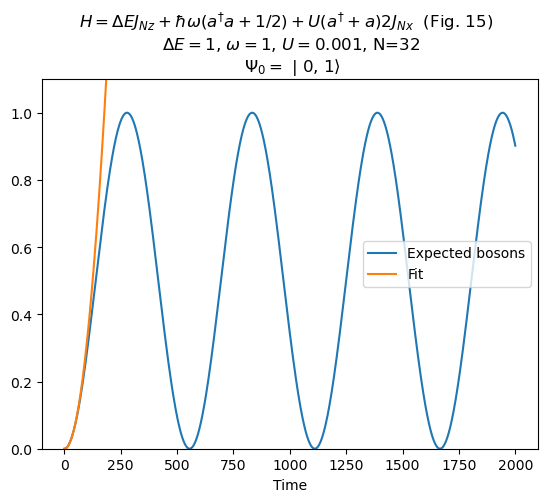

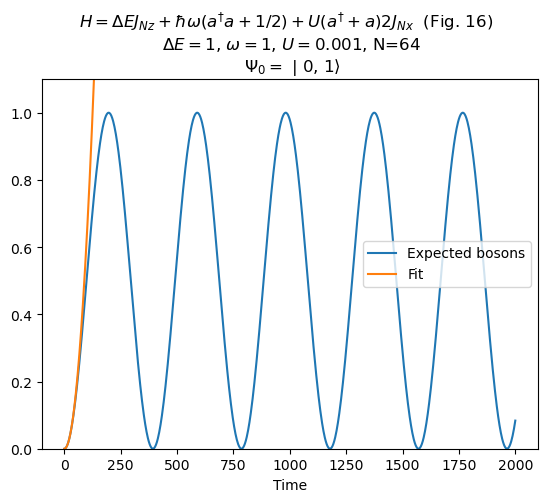

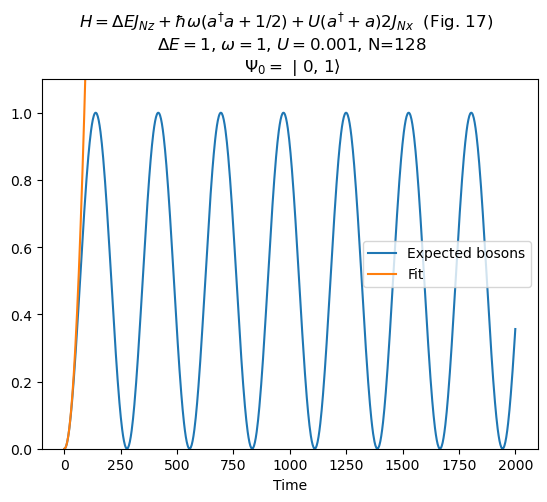

CPU times: user 12.1 s, sys: 2.89 s, total: 15 s
Wall time: 7.31 s


In [198]:
%%time 
# %%time must be at the top of the cell and by itself. It tells you the "Wall time" (how long the cell took to run) at the end of the output (should be about 2 min).

Ns = [2,4,8,16,32,64,128] # number of TLS we want to simulation
times = np.linspace(0, 2000, 1000)
rate = [] # For storing emission rates

for i, N in enumerate(Ns):

    two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=2, parity=-1, num_TLS=N)

    bra_labels, ket_labels = make_braket_labels(nm_list)
    
    H = DeltaE*two_state + omega*bosons + U*interaction

    psi0_ind = nm_list.index((0,1))  # Field in vacuum state (0) with 1 excitations (1)
    psi0 = basis(len(nm_list), psi0_ind)

    # We can use use QuTips sesolve here because of the shorter
    # simulation time. Sometimes sesolve is still fastser than
    # our custom solver because of unknown optimisations made
    # made the QuTip/Numpy teams.
    result = sesolve(H, psi0, times, [number])

    # For fitting, we'll find when the first boson is emitted, then re-simulate 
    # up to that point so that we can get a better resolution over the shorter time periods.
    # We do this because we expect timescales to shorten as we increase TLS number
    
    # Because we only have a single excitation the number of bosons never crosses 1 
    # so we need to use find_peaks just like in the last tutorial
    peaks, _ = find_peaks(result.expect[0], prominence=0.05)
    peak_times = times[peaks]
    time_to_emit_one = peak_times[0]

    times_fit = np.linspace(0,  time_to_emit_one, 1000)
    result_fit = sesolve(H, psi0, times_fit, [number])

    fit, covariance = curve_fit(model_func, times_fit[0:100], result_fit.expect[0][0:100],p0=[0.01],maxfev=500)

    rate.append(2*fit[0])


    plt.plot(times, result.expect[0], label="Expected bosons")
    plt.plot(times,model_func(times,*fit),label="Fit")
    plt.xlabel("Time")
    plt.ylim([0,result.expect[0].max()*1.1])
    plt.legend(loc="right")
    plt.title(f"{H_latex} (Fig. {i+11})  \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, N={N} \n $\Psi_0 =$ {ket_labels[psi0_ind]}")
    plt.show();

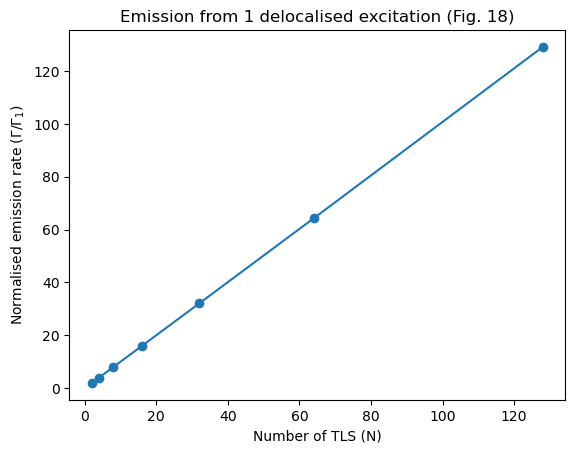

In [199]:
plt.plot(Ns,rate/gamma_1,"-o")
plt.xlabel("Number of TLS (N)")
plt.ylabel("Normalised emission rate ($\Gamma/\Gamma_1$)");
plt.title("Emission from 1 delocalised excitation (Fig. 18)");

Fig. 18 shows us that we get the same enhancement of emission rates whether we have single excitation or $N$ of them 🤔.

Stranger still is the case where half of the TLS are excited.

Let's check this out.

### Half excited system

10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.02s. Est. time left: 00:00:00:00
30.0%. Run time:   0.03s. Est. time left: 00:00:00:00
40.0%. Run time:   0.04s. Est. time left: 00:00:00:00
50.0%. Run time:   0.05s. Est. time left: 00:00:00:00
60.0%. Run time:   0.07s. Est. time left: 00:00:00:00
70.0%. Run time:   0.08s. Est. time left: 00:00:00:00
80.0%. Run time:   0.09s. Est. time left: 00:00:00:00
90.0%. Run time:   0.10s. Est. time left: 00:00:00:00
Total run time:   0.11s


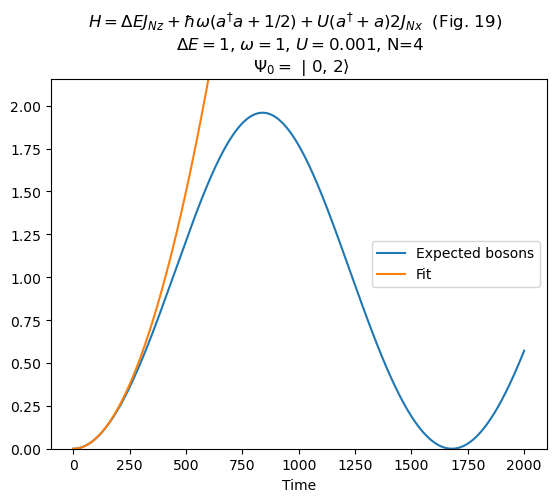

10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.02s. Est. time left: 00:00:00:00
30.0%. Run time:   0.04s. Est. time left: 00:00:00:00
40.0%. Run time:   0.05s. Est. time left: 00:00:00:00
50.0%. Run time:   0.07s. Est. time left: 00:00:00:00
60.0%. Run time:   0.09s. Est. time left: 00:00:00:00
70.0%. Run time:   0.11s. Est. time left: 00:00:00:00
80.0%. Run time:   0.13s. Est. time left: 00:00:00:00
90.0%. Run time:   0.15s. Est. time left: 00:00:00:00
Total run time:   0.16s


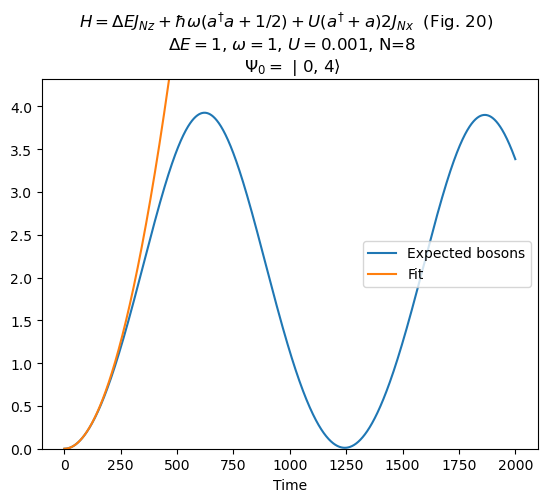

10.0%. Run time:   0.05s. Est. time left: 00:00:00:00
20.0%. Run time:   0.10s. Est. time left: 00:00:00:00
30.0%. Run time:   0.15s. Est. time left: 00:00:00:00
40.0%. Run time:   0.20s. Est. time left: 00:00:00:00
50.0%. Run time:   0.26s. Est. time left: 00:00:00:00
60.0%. Run time:   0.31s. Est. time left: 00:00:00:00
70.0%. Run time:   0.36s. Est. time left: 00:00:00:00
80.0%. Run time:   0.41s. Est. time left: 00:00:00:00
90.0%. Run time:   0.47s. Est. time left: 00:00:00:00
Total run time:   0.52s


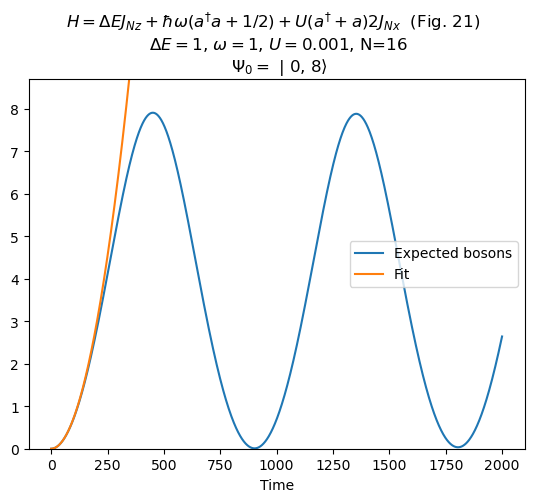

10.0%. Run time:   0.23s. Est. time left: 00:00:00:02
20.0%. Run time:   0.54s. Est. time left: 00:00:00:02
30.0%. Run time:   0.86s. Est. time left: 00:00:00:01
40.0%. Run time:   1.17s. Est. time left: 00:00:00:01
50.0%. Run time:   1.44s. Est. time left: 00:00:00:01
60.0%. Run time:   1.73s. Est. time left: 00:00:00:01
70.0%. Run time:   2.03s. Est. time left: 00:00:00:00
80.0%. Run time:   2.34s. Est. time left: 00:00:00:00
90.0%. Run time:   2.63s. Est. time left: 00:00:00:00
Total run time:   2.90s


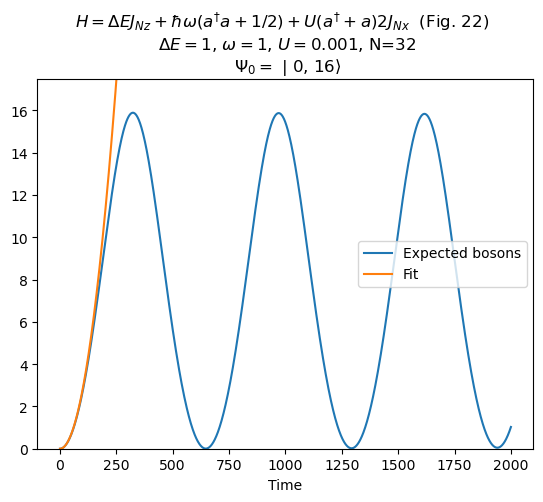

10.0%. Run time:   1.48s. Est. time left: 00:00:00:13
20.0%. Run time:   3.03s. Est. time left: 00:00:00:12
30.0%. Run time:   4.57s. Est. time left: 00:00:00:10
40.0%. Run time:   6.17s. Est. time left: 00:00:00:09
50.0%. Run time:   7.73s. Est. time left: 00:00:00:07
60.0%. Run time:   9.30s. Est. time left: 00:00:00:06
70.0%. Run time:  10.86s. Est. time left: 00:00:00:04
80.0%. Run time:  12.42s. Est. time left: 00:00:00:03
90.0%. Run time:  14.00s. Est. time left: 00:00:00:01
Total run time:  15.60s


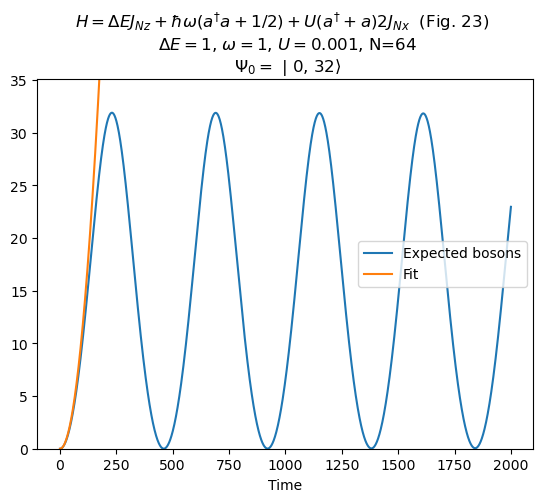

10.0%. Run time:  11.10s. Est. time left: 00:00:01:39
20.0%. Run time:  23.41s. Est. time left: 00:00:01:33
30.0%. Run time:  35.61s. Est. time left: 00:00:01:23
40.0%. Run time:  47.78s. Est. time left: 00:00:01:11
50.0%. Run time:  60.06s. Est. time left: 00:00:01:00
60.0%. Run time:  72.31s. Est. time left: 00:00:00:48
70.0%. Run time:  84.70s. Est. time left: 00:00:00:36
80.0%. Run time:  96.92s. Est. time left: 00:00:00:24
90.0%. Run time: 109.18s. Est. time left: 00:00:00:12
Total run time: 121.40s


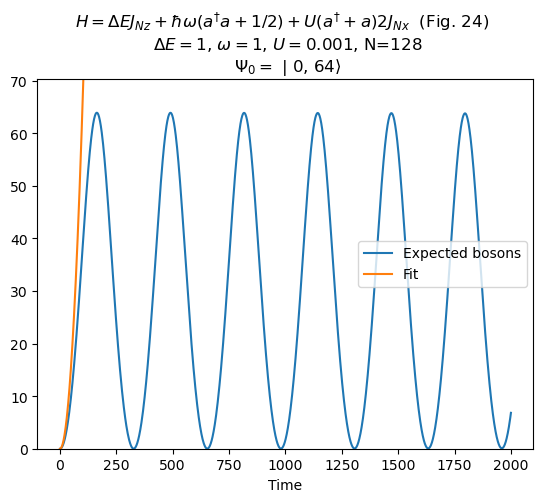

CPU times: user 2min 26s, sys: 3.77 s, total: 2min 29s
Wall time: 2min 22s


In [200]:
%%time 
# %%time must be at the top of the cell and by itself. It tells you the "Wall time" (how long the cell took to run) at the end of the output (should be about 2 min).

Ns = [4,8,16,32,64,128] # number of TLS we want to simulation
times = np.linspace(0,  2000, 2000)
rate = [] # For storing emission rates

for i, N in enumerate(Ns):

    two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=int(N/2)+1, parity=1, num_TLS=N)

    bra_labels, ket_labels = make_braket_labels(nm_list)
    
    H = DeltaE*two_state + omega*bosons + U*interaction

    psi0_ind = nm_list.index((0,int(N/2)))  # Field in vacuum state (0) with N/2 excitations (int(N/2))
    psi0 = basis(len(nm_list), psi0_ind)


    # We can use use QuTips sesolve here because of the shorter
    # simulation time. Sometimes sesolve is still fastser than
    # our custom solver because of unknown optimisations made
    # made the QuTip/Numpy teams.
    # Note progress bar because the last simulation will take about 5 min
    result = sesolve(H, psi0, times, [number],progress_bar=True)

    # For fitting, we'll find when 1 boson is emitted and re-simulate up to that point
    # so that we can get a better resolution over the shorter time periods. We
    # do this because we expect timescales to shorten as we increase TLS number

    peaks, _ = find_peaks(result.expect[0], prominence=0.05)
    peak_times = times[peaks]
    time_to_peak = peak_times[0]

    # For fitting, we'll find when the first boson is emitted, then re-simulate 
    # up to that pointso that we can get a better resolution over the shorter time periods.
    # We do this because we expect timescales to shorten as we increase TLS number
    crossing_one_index = np.where(np.diff((result.expect[0] > 1).astype(int)))[0][0]
    time_to_emit_one = times[crossing_one_index]

    times_fit = np.linspace(0,  time_to_emit_one, 1000)
    result_fit = sesolve(H, psi0, times_fit, [number])

    fit, covariance = curve_fit(model_func, times_fit[0:100], result_fit.expect[0][0:100],p0=[0.01],maxfev=500)

    rate.append(2*fit[0])


    plt.plot(times, result.expect[0], label="Expected bosons")
    plt.plot(times,model_func(times,*fit),label="Fit")
    plt.xlabel("Time")
    plt.ylim([0,result.expect[0].max()*1.1])
    plt.legend(loc="right")
    plt.title(f"{H_latex} (Fig. {i+19})  \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, N={N} \n $\Psi_0 =$ {ket_labels[psi0_ind]}")
    plt.show();

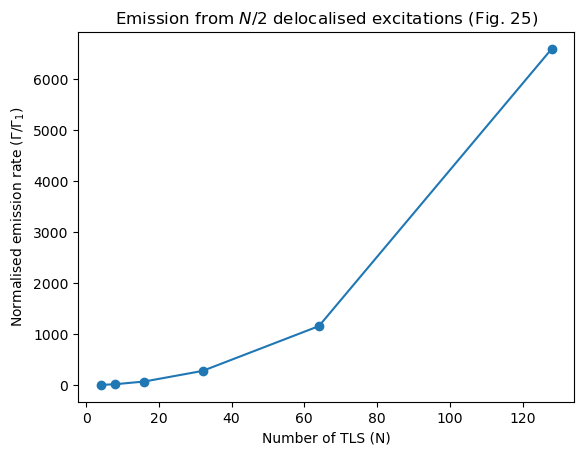

In [201]:
plt.plot(Ns,rate/gamma_1,"-o")
plt.xlabel("Number of TLS (N)")
plt.ylabel("Normalised emission rate ($\Gamma/\Gamma_1$)");
plt.title("Emission from $N/2$ delocalised excitations (Fig. 25)");

Fig. 25 shows us that, with $N/2$ excitations, the emission rate is even greater than when all of the TLS are excited 🤯!

Let's quantify this by doing a linear regression of $\log(\Gamma)$ with  $\log(N)$

In [202]:
print("slope = ", linregress(np.log10(Ns), np.log10(rate)).slope)

slope =  1.9987734858660948


We can see that $\Gamma \sim N^2$ when $n_+ = N/2$. 

This kind of counter intuitive emission rate enhancement was discovered by Dicke in his 1956 paper [Coherence in Spontaneous Radiation Processes](https://journals.aps.org/pr/abstract/10.1103/PhysRev.93.99) where we coined the turn "superradiance".

In general, Dicke found that when $n_+$ excitations are delocalised across $N$ TLS, the emission rate $\Gamma$ is enhanced over the single TLS emission rate $\Gamma_1$ by:

$$\frac{\Gamma}{\Gamma_1} = n_+\left(N - n_+ +1\right)$$

where can see that $\Gamma$ is largest when half the TLS are excited giving a rate of $\Gamma/\Gamma_1 = \frac{N}{2}\left(\frac{N}{2}+1\right)$.

How can we understand this?

### Understanding superradiance

Superradiance might at first seem counterintuitive, but we can understand it from one of the most fundamental principles of quantum mechanics [according to Richard Feynman](https://www.feynmanlectures.caltech.edu/III_01.html#Ch1-S7) which reads:

```
"When an event can occur in several alternative ways, the probability amplitude for the event is the sum of the probability amplitudes for each way considered separately. There is interference"
```

Let's take the example of 2 excitations amongst 4 TLS. The initial delocalised Dicke state looks like:

$\Psi_i = \frac{1}{\sqrt{6}}\left(| 0, +, +, -, - \rangle + | 0, +, -, +, - \rangle + | 0, +, -, -, + \rangle + | 0, -, +, +, - \rangle + | 0, -, +, -, + \rangle + | 0, -, -, +, + \rangle \right)$

We can see there are 6 different configurations for the TLS. Each of the 2 excitations in those 6 configurations could transition from $+$ to a $-$ with a release of a single boson. That means each of the 6 configurations has 2 emission paths that it could go in order to reach one of 4 configurations in final the state:

$\Psi_f = \frac{1}{\sqrt{4}}\left(| 0, +, -, -, - \rangle + | 0, -, +, -, - \rangle + | 0, -, -, +, - \rangle + | 0, -, -, -, + \rangle \right)$

The total number of emission paths is therefore $6\times 2 = 12$. Each of these paths contributes the same to the overall amplitude because the Dicke state is constructed with $+$ between each of the configurations that make up the state. This creates what's called "constructive interference" where the effects of each path add up to a larger effect. 

To get the numbers right, we must remember that our states are normalised. The 6 configurations in our starting state means dividing the amplitude by $\sqrt{6}$. The 4 configurations in the final state means dividing the amplitude by $\sqrt{4}$. So the overall amplitude enhancement factor is:

$$\frac{6\times 2}{\sqrt{6}\sqrt{4}} = \sqrt{6}$$

and so the probability enhancement factor (which related to emission rates) is the square of this, i.e. 6. This is consistent with Dicke's formula.

To derive the general Dicke formula, we just have to do this counting and normalising for the general case:

$$\frac{\Gamma}{\Gamma_1} = \left(\frac{^N C_{n_+} n_+}{\sqrt{^N C_{n_+}}\sqrt{^N C_{{n_+}-1}}}\right)^2 = n_+\left(N-n_++1\right)$$

Now we can really understand just how important those $+$'s are that make up the Dicke state. As soon as you allow any $-$ you reduce the emission rates. Take for example the case of 2 TLS with a single delocalised excitation. If instead of a Dicke state

$\Psi = \frac{1}{\sqrt{2}}\left(| 0, +, -\rangle + | 0, -, + \rangle \right)$

we instead use 

$\Psi = \frac{1}{\sqrt{2}}\left(| 0, +, -\rangle - | 0, -, + \rangle \right)$

then we get no emission at all because we get complete destructive interference of the two paths. Such states are often referred to as "dark states".